In [3]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Define the GP Model with Additive Kernel (AGP)
class AdditiveGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(AdditiveGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Define additive kernel: sum of 1D RBF kernels correctly
        base_kernels = [
            gpytorch.kernels.RBFKernel(active_dims=[i]) for i in range(train_x.shape[1])
        ]
        self.covar_module = gpytorch.kernels.AdditiveKernel(*base_kernels)  # Corrected kernel summation

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the GP Model with Orthogonal Additive Kernel (OAK)
class OrthogonalAdditiveGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(OrthogonalAdditiveGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Simulating OAK by emphasizing low-order interactions (approximate)
        base_kernels = [
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[i]), outputscale=0.5)
            for i in range(train_x.shape[1])
        ]
        self.covar_module = gpytorch.kernels.AdditiveKernel(*base_kernels)  # Corrected summation

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Generate synthetic data: Low-order additive function
def true_function(X):
    """True function with only first and second-order interactions"""
    return torch.sin(X[:, 0]) + torch.cos(X[:, 1]) + 0.5 * X[:, 0] * X[:, 1]


# Generate dataset
def generate_data(n_samples, noise_std=0.1):
    """Generates training and test datasets."""
    X = torch.FloatTensor(n_samples, 5).uniform_(-2, 2)  # 5D inputs
    y = true_function(X) + noise_std * torch.randn(n_samples)
    return X.to(device), y.to(device)





In [3]:


# Evaluate contraction rates
train_sizes = np.logspace(1, 3, num=6, dtype=int)  # Log-spaced sample sizes
errors_agp, errors_oak = [], []


In [4]:
# Training function
def train_gp(model, likelihood, train_x, train_y, training_iter=50):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

In [5]:
# Evaluation function
def evaluate_gp(model, likelihood, X_test, y_test):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model(X_test).mean
    return mean_squared_error(y_test.cpu().numpy(), preds.cpu().numpy())

In [6]:
for n_train in train_sizes:
    # Generate training and test sets
    X_train, y_train = generate_data(n_train)
    X_test, y_test = generate_data(200)  # Fixed test set for comparison

    # Define likelihoods
    likelihood_agp = gpytorch.likelihoods.GaussianLikelihood().to(device)
    likelihood_oak = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Initialize models
    model_agp = AdditiveGPModel(X_train, y_train, likelihood_agp).to(device)
    model_oak = OrthogonalAdditiveGPModel(X_train, y_train, likelihood_oak).to(device)

    

    # Train AGP
    train_gp(model_agp, likelihood_agp, X_train, y_train)

    # Train OAK
    train_gp(model_oak, likelihood_oak, X_train, y_train)

 

    # Compute errors
    errors_agp.append(evaluate_gp(model_agp, likelihood_agp, X_test, y_test))
    errors_oak.append(evaluate_gp(model_oak, likelihood_oak, X_test, y_test))




In [7]:
train_sizes

array([  10,   25,   63,  158,  398, 1000])

In [8]:
errors_agp

[1.5377322435379028,
 0.4861137866973877,
 0.6081739664077759,
 0.48850521445274353,
 0.43235474824905396,
 0.5047355890274048]

In [9]:
errors_oak

[1.2039754390716553,
 0.5152547955513,
 0.6077908873558044,
 0.48275861144065857,
 0.4334467351436615,
 0.5027123093605042]

In [1]:
train_sizes = [  10,   25,   63,  158,  398, 1000]

errors_agp = [1.5377322435379028,
 0.4861137866973877,
 0.6081739664077759,
 0.48850521445274353,
 0.43235474824905396,
 0.5047355890274048]

errors_oak = [1.2039754390716553,
 0.5152547955513,
 0.6077908873558044,
 0.48275861144065857,
 0.4334467351436615,
 0.5027123093605042]

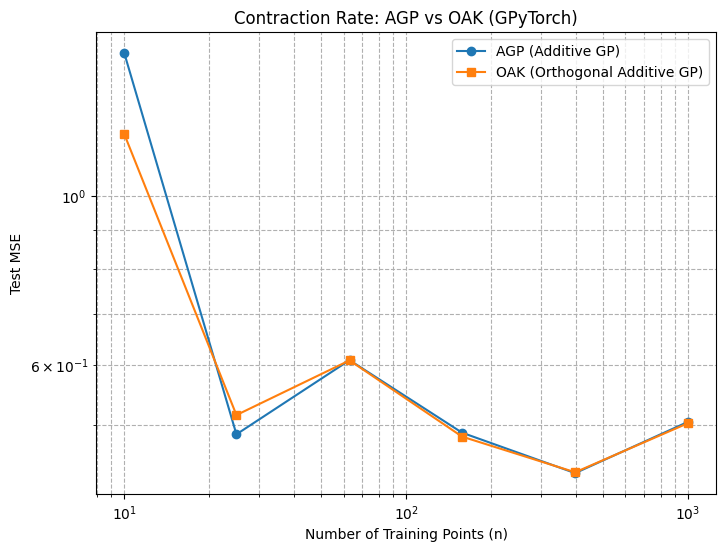

In [4]:
# Plot contraction rate comparison
plt.figure(figsize=(8, 6))
plt.loglog(train_sizes, errors_agp, label="AGP (Additive GP)", marker='o')
plt.loglog(train_sizes, errors_oak, label="OAK (Orthogonal Additive GP)", marker='s')
plt.xlabel("Number of Training Points (n)")
plt.ylabel("Test MSE")
plt.title("Contraction Rate: AGP vs OAK (GPyTorch)")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()